# Modelo: "GPI"

Iterativamente va actualizando una estrategia de modo que cada estrategia siguiente es mejor que la anterior.

En cierto sentido, un descenso estocástico sobre $2^{\text{estados}}$ que optimiza la probabilidad de obtener un resultado deseado conociendo la utilidad verdadera de un subconjunto de nodos, donde los vecinos de un punto del dominio son subconjuntos con algunos estados más, tal que dichos estados provengan de un Metropolis con dominio en partidas jugadas por jugadores óptimos con la información hasta el momento, de modo que dicho metropolis converge a partidas hechas por jugadores perfectos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd

## Parte 1.1: definiciones

## Parte 1.2: estructuras

Aquí van a ir todas las estructuras con las que trabajaremos. 

Primero, necesitaremos de una estructura para acceder rápidamente a la información necesaria que contiene el juego en cierto estado, para no tener que recalcularlo multiples veces (programación dinámica).

Luego, necesitaremos una manera de navegar sobre los nodos del metropolis, es decir, las "Partidas simuladas" en si mismas. Para ello se creará una estructura que guarde tableros, para hacer seguimiento de una partida.

Por último, se necesita una estructura para nuestro modelo. Para esto se hará una estructura que almacene los tableros revisados y guarde sus valores.

### Clase Tablero

define los nodos (estados de juego) de las partidas

#### Codigo

In [2]:
# guardar las posibles jugadas dado un tablero
class Tablero:
  def __init__(self,llave_tablero,tableros_siguientes_posibles=[]):
    self.llave = llave_tablero
    self.tableros_de_origen = []
    self.jugadas_posibles = list(tableros_siguientes_posibles)
    for tablero in tableros_siguientes_posibles:
      tablero.tableros_de_origen.append(self)
    self.valor = 0
    #self.valor = 0.5
    self.visitado = False #no testeado
    self.actualizar_tableros_viables()

  # guardar viabilidad
  def actualizar_tableros_viables(self,actualizar_valores=False):
    jugadas_posibles_aux = []
    valor_aux = -1
    #valor_aux = 0

    # checkear las mejores jugadas
    for T in self.jugadas_posibles:
      if T.valor < valor_aux:
        continue
      if T.valor > valor_aux:
        jugadas_posibles_aux = []
        valor_aux = T.valor
      jugadas_posibles_aux.append(T)

    self.jugadas_posibles_viables = jugadas_posibles_aux

    if len(jugadas_posibles_aux) == 0:
      return
    if actualizar_valores:
      self.valor = -valor_aux
      #self.valor = 1.0-valor_aux        

  # guardar puntaje
  def actualizar_valor(self):
    if len(self.jugadas_posibles_viables) == 0:
      return
    self.valor = -self.jugadas_posibles_viables[0].valor
    #self.valor = 1.0-self.jugadas_posibles_viables[0].valor

  # guardar nuevas posibilidades
  def agregar_jugadas(self,tableros):
    self.jugadas_posibles = self.jugadas_posibles + tableros
    for tablero in tableros:
      tablero.tableros_de_origen.append(self)
    
  # cambiar valor
  def cambiar_valor(self,valor):
    self.valor = valor
  
  # recuperar llaves
  def llaves_jugadas_posibles(self):
    return [tablero.llave for tablero in self.jugadas_posibles]

  # recuperar llaves viables 
  def llaves_jugadas_posibles_viables(self):
    return [tablero.llave for tablero in self.jugadas_posibles_viables]

#### Test

In [3]:
# tests tablero

test2 = Tablero('baa',[])
test3 = Tablero('aba',[])
test4 = Tablero('aab',[])
test1 = Tablero('aaa',[test2,test3])

# checkear inicializador
assert test1.llave == 'aaa'
assert test1.jugadas_posibles[0].llave == 'baa'
assert test1.jugadas_posibles[1].llave == 'aba'

assert test1.valor == 0
assert test1.jugadas_posibles[0].valor == 0
assert test1.jugadas_posibles[1].valor == 0
#assert test1.valor == 0.5
#assert test1.jugadas_posibles[0].valor == 0.5
#assert test1.jugadas_posibles[1].valor == 0.5

assert test1.llaves_jugadas_posibles() == ['baa','aba']
assert test1.llaves_jugadas_posibles_viables() == ['baa','aba']
assert len(test1.jugadas_posibles) == 2
assert len(test1.jugadas_posibles_viables) == 2

# checkear agregar jugadas
test1.agregar_jugadas([test4])

assert test1.llave == 'aaa'
assert test1.jugadas_posibles[0].llave == 'baa'
assert test1.jugadas_posibles[1].llave == 'aba'
assert test1.jugadas_posibles[2].llave == 'aab'

assert test1.valor == 0
assert test1.jugadas_posibles[0].valor == 0
assert test1.jugadas_posibles[1].valor == 0
assert test1.jugadas_posibles[2].valor == 0
#assert test1.valor == 0.5
#assert test1.jugadas_posibles[0].valor == 0.5
#assert test1.jugadas_posibles[1].valor == 0.5
#assert test1.jugadas_posibles[2].valor == 0.5

assert len(test1.jugadas_posibles) == 3
assert len(test1.jugadas_posibles_viables) == 2 #no actualizado
assert test1.llaves_jugadas_posibles() == ['baa','aba','aab']
assert test1.llaves_jugadas_posibles_viables() == ['baa','aba'] #no actualizado

test1.actualizar_tableros_viables()
assert len(test1.jugadas_posibles_viables) == 3
assert test1.llaves_jugadas_posibles_viables() == ['baa','aba','aab']

# checkear editar valores

test4.cambiar_valor(-1)
assert test1.valor == 0
assert test1.jugadas_posibles[0].valor == 0
assert test1.jugadas_posibles[1].valor == 0
assert test1.jugadas_posibles[2].valor == -1
#test4.cambiar_valor(0.0)
#assert test1.valor == 0.5
#assert test1.jugadas_posibles[0].valor == 0.5
#assert test1.jugadas_posibles[1].valor == 0.5
#assert test1.jugadas_posibles[2].valor == 0.0
assert len(test1.jugadas_posibles_viables) == 3 #no actualizado

test1.actualizar_tableros_viables()
assert test1.valor == 0
assert test1.jugadas_posibles[0].valor == 0
assert test1.jugadas_posibles[1].valor == 0
assert test1.jugadas_posibles[2].valor == -1
#assert test1.valor == 0.5
#assert test1.jugadas_posibles[0].valor == 0.5
#assert test1.jugadas_posibles[1].valor == 0.5
#assert test1.jugadas_posibles[2].valor == 0.0
assert len(test1.jugadas_posibles_viables) == 2

test2.cambiar_valor(1)
test1.actualizar_tableros_viables()
assert test1.valor == 0 # no actualizado
assert test1.jugadas_posibles[0].valor == 1
assert test1.jugadas_posibles[1].valor == 0
assert test1.jugadas_posibles[2].valor == -1
#test2.cambiar_valor(1.0)
#test1.actualizar_tableros_viables()
#assert test1.valor == 0.5 # no actualizado
#assert test1.jugadas_posibles[0].valor == 1.0
#assert test1.jugadas_posibles[1].valor == 0.5
#assert test1.jugadas_posibles[2].valor == 0.0
assert len(test1.jugadas_posibles_viables) == 1

test1.actualizar_valor()

assert test1.valor == -1
assert test1.jugadas_posibles[0].valor == 1
assert test1.jugadas_posibles[1].valor == 0
assert test1.jugadas_posibles[2].valor == -1
#assert test1.valor == 0.0
#assert test1.jugadas_posibles[0].valor == 1.0
#assert test1.jugadas_posibles[1].valor == 0.5
#assert test1.jugadas_posibles[2].valor == 0.0
assert len(test1.jugadas_posibles_viables) == 1

test2.cambiar_valor(-1)
test3.cambiar_valor(-1)
#test2.cambiar_valor(0.0)
#test3.cambiar_valor(0.0)
test1.actualizar_tableros_viables(True)

assert test1.valor == 1
assert test1.jugadas_posibles[0].valor == -1
assert test1.jugadas_posibles[1].valor == -1
assert test1.jugadas_posibles[2].valor == -1
#assert test1.valor == 1.0
#assert test1.jugadas_posibles[0].valor == 0.0
#assert test1.jugadas_posibles[1].valor == 0.0
#assert test1.jugadas_posibles[2].valor == 0.0
assert len(test1.jugadas_posibles_viables) == 3

del test4
del test3
del test2
del test1

In [4]:
# test manual

test = {}
test['aaa'] = Tablero('aaa',[])
test['aab'] = Tablero('aab',[])
test['aba'] = Tablero('aba',[])
test['baa'] = Tablero('baa',[])
test['bba'] = Tablero('bba',[])
test['bab'] = Tablero('bab',[])
test['abb'] = Tablero('abb',[])
test['bbb'] = Tablero('bbb',[])

test['aaa'].agregar_jugadas([test['aba'],test['baa'],test['aab']])
test['aab'].agregar_jugadas([test['bab'],test['abb']])
test['aba'].agregar_jugadas([test['bba'],test['abb']])
test['baa'].agregar_jugadas([test['bba'],test['bab']])
test['bba'].agregar_jugadas([test['bbb']])
test['bab'].agregar_jugadas([test['bbb']])
test['abb'].agregar_jugadas([test['bbb']])

test['bbb'].cambiar_valor(0.0)

test['bbb'].actualizar_tableros_viables(True)
test['abb'].actualizar_tableros_viables(True)
test['bba'].actualizar_tableros_viables(True)
test['bab'].actualizar_tableros_viables(True)
test['aab'].actualizar_tableros_viables(True)
test['aba'].actualizar_tableros_viables(True)
test['baa'].actualizar_tableros_viables(True)
test['aaa'].actualizar_tableros_viables(True)

for llave in test: print(llave,':',test[llave].valor,'-',test[llave].llaves_jugadas_posibles_viables())

del test


aaa : -0.0 - ['aba', 'baa', 'aab']
aab : 0.0 - ['bab', 'abb']
aba : 0.0 - ['bba', 'abb']
baa : 0.0 - ['bba', 'bab']
bba : -0.0 - ['bbb']
bab : -0.0 - ['bbb']
abb : -0.0 - ['bbb']
bbb : 0.0 - []


### Clase Partida

define los nodos (partidas simuladas) con los que se recorrerá el metropolis

#### Codigo

In [5]:
# guardar partidas
class Partida:
  def __init__(self,tablero_inicial):
    self.tableros = []
    self.agregar_jugada(tablero_inicial)

  # agrega el tablero resultante de una jugada  
  def agregar_jugada(self,tablero_siguiente):
    self.tableros.append(tablero_siguiente)

  # regresar al turno
  def retroceder_antes_del_turno(self,n):
    self.tableros = self.tableros[:n]

  def reiniciar(self):
    self.tableros = self.tableros[:1]

  # en que van
  def tablero_actual(self):
    return self.tableros[-1]

  # tablero en turno n
  def tablero_en_turno(self,n):
    return self.tableros[n]

  # turno actual
  def turno_actual(self):
    return len(self.tableros)-1
  
  # actualizar desde turno n (desuso)
  def actualizar_hacia_atras_turno(self,n):
    for turno in range(n-1,-1,-1):
      self.tableros[turno].actualizar_tableros_viables(True)
  
  # cambiar valor (desuso)
  def cambiar_valor_turno(self,n,valor):
    self.tableros[n].cambiar_valor(valor)
    self.actualizar_hacia_atras_turno(n)

#### Test

In [6]:
#tests Partidas: solo manejar punteros

test = {}
test[3] = Tablero('bc',[])
test[2] = Tablero('ba',[])
test[1] = Tablero('ab',[])
test[0] = Tablero('aa',[test[1],test[2]])
Test = Partida(test[0])
#print(test[0])

# checkear inicializador

assert Test.tablero_actual().llave == 'aa'
assert Test.turno_actual() == 0
assert len(Test.tablero_actual().jugadas_posibles_viables) == 2
assert Test.tablero_actual() == test[0]
#print(Test.tablero_actual())

# checkear agregar turno

Test.agregar_jugada(test[2])
assert Test.tablero_actual().llave == 'ba'
assert Test.turno_actual() == 1
assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert Test.tablero_en_turno(0).llave == 'aa'
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 2

assert Test.tablero_en_turno(0) == test[0]
assert Test.tablero_en_turno(0).jugadas_posibles[1] == test[2]
assert Test.tablero_en_turno(0).jugadas_posibles[1] == Test.tablero_actual()
#print(Test.tablero_en_turno(0))

Test.tablero_actual().agregar_jugadas([test[3]])
Test.agregar_jugada(test[3])

# estos tres deben ser el mismo objeto
#print(test[3])
#print(Test.tablero_actual())
#print(Test.tablero_en_turno(1).jugadas_posibles[0])
#print(Test.tablero_en_turno(0).jugadas_posibles[1].jugadas_posibles[0])

assert Test.tablero_actual() == test[3]
assert Test.tablero_en_turno(1).jugadas_posibles[0] == test[3]
assert Test.tablero_en_turno(0).jugadas_posibles[1].jugadas_posibles[0] == test[3]

# checkear editar valores

assert Test.tablero_actual().valor == 0
assert Test.tablero_en_turno(1).valor == 0
assert Test.tablero_en_turno(0).valor == 0
#assert Test.tablero_actual().valor == 0.5
#assert Test.tablero_en_turno(1).valor == 0.5
#assert Test.tablero_en_turno(0).valor == 0.5

assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(1).jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 2

Test.actualizar_hacia_atras_turno(2)

assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(1).jugadas_posibles_viables) == 1
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 2

Test.cambiar_valor_turno(1,1)
assert Test.tablero_actual().valor == 0
assert Test.tablero_en_turno(1).valor == 1, Test.tablero_en_turno(1).valor
assert Test.tablero_en_turno(0).valor == -1
#Test.cambiar_valor_turno(1,1.0)
#assert Test.tablero_actual().valor == 0.5
#assert Test.tablero_en_turno(1).valor == 1.0, Test.tablero_en_turno(1).valor
#assert Test.tablero_en_turno(0).valor == 0.0

assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(1).jugadas_posibles_viables) == 1
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 1

Test.cambiar_valor_turno(2,1)
assert Test.tablero_actual().valor == 1
assert Test.tablero_en_turno(1).valor == -1
assert Test.tablero_en_turno(0).valor == 0, Test.tablero_en_turno(0).valor
#Test.cambiar_valor_turno(2,1)
#assert Test.tablero_actual().valor == 1.0
#assert Test.tablero_en_turno(1).valor == 0.0
#assert Test.tablero_en_turno(0).valor == 0.5, Test.tablero_en_turno(0).valor

assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(1).jugadas_posibles_viables) == 1
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 1

test[1].cambiar_valor(-1)
test[0].actualizar_tableros_viables(True)
assert Test.tablero_actual().valor == 1
assert Test.tablero_en_turno(1).valor == -1
assert Test.tablero_en_turno(0).valor == 1, Test.tablero_en_turno(0).valor
#test[1].cambiar_valor(0)
#test[0].actualizar_tableros_viables(True)
#assert Test.tablero_actual().valor == 1
#assert Test.tablero_en_turno(1).valor == 0
#assert Test.tablero_en_turno(0).valor == 1, Test.tablero_en_turno(0).valor

assert len(Test.tablero_actual().jugadas_posibles_viables) == 0
assert len(Test.tablero_en_turno(1).jugadas_posibles_viables) == 1
assert len(Test.tablero_en_turno(0).jugadas_posibles_viables) == 2

# retroceder en el tiempo

assert Test.tablero_actual().llave == 'bc'
assert Test.turno_actual() == 2
assert Test.tablero_actual() == test[3]

Test.retroceder_antes_del_turno(2)

assert Test.tablero_actual().llave == 'ba'
assert Test.turno_actual() == 1
assert Test.tablero_actual() == test[2]

del Test
del test

### Clase estimador

define del modelo de aprendizaje

#### Codigo

In [7]:
# clase estimador
class Estimador:
  def __init__(self,checkpoint=None,separador=' '):
    self.separador = separador
    self.tableros = {}
    if checkpoint != None:
      self.leer_checkpoint(checkpoint)

  # leer checkpoint
  def leer_checkpoint(self,checkpoint):
    for llave in checkpoint: 
      if not self.conoce_a(llave):
        self.tableros[llave] = Tablero(llave,[])
    for llave in checkpoint:
      if checkpoint[llave][1] != '':
        self.tableros[llave].agregar_jugadas([self.tablero(vecino) for vecino in checkpoint[llave][1].split(self.separador)])
      self.tableros[llave].cambiar_valor(checkpoint[llave][0])

  # crear manualmente
  def agregar_tablero(self,llave_tablero,jugadas_siguientes):
    #if self.conoce_a(llave_tablero):
    #  return
    self.tablero(llave_tablero).agregar_jugadas([self.tablero(llave) for llave in jugadas_siguientes])
    self.tablero(llave_tablero).actualizar_tableros_viables(True)

  # crear checkpoint
  def crear_checkpoint(self):
    checkpoint = {}
    for llave in self.tableros:
      checkpoint[llave] = [self.valor(llave),self.separador.join(self.jugadas_viables(llave))]
    return checkpoint

  # revisar si un estado ya fue visitado
  def conoce_a(self,llave):
    return llave in self.tableros

  # retorna estado
  def tablero(self,llave):
    if not self.conoce_a(llave):
      self.tableros[llave] = Tablero(llave,[])
    return self.tableros[llave]
    
  # retorna valor
  def valor(self,llave):
    return self.tablero(llave).valor
    # if llave not in self.tableros:
    #   self.tableros[llave] = Tablero(llave,[])
    # return self.tableros[llave].valor

  # retorna vecinos importantes
  def jugadas_viables(self,llave):
    return self.tablero(llave).llaves_jugadas_posibles_viables()
    # if llave not in self.tableros:
    #   self.tableros[llave] = Tablero(llave,[])
    # return self.tableros[llave].llaves_jugadas_posibles_viables()    

  # actualizar tableros viables
  def actualizar_tableros_viables(self,llave,actualizar_valores=False):
    self.tablero(llave).actualizar_tableros_viables(actualizar_valores)

  # actualizar valores
  def actualizar_valor(self,llave):
    self.tablero(llave).actualizar_valor() 


#### Test

In [8]:
# test Estimador


# checkear traspaso de info


# checkear autocompletatacion

test1 = {}
test1['aaa'] = [-1,'baa aba aab']
#test1['aaa'] = [0.0,'baa aba aab']
# test1['baa'] = [1,'']
# test1['aba'] = [0.5,'']
# test1['aab'] = [0,'']

U = Estimador()

U.agregar_tablero('aaa',test1['aaa'][1].split(' '))
U.tablero('aaa').cambiar_valor(test1['aaa'][0])

assert len(U.tableros) == 4

assert U.tableros['aaa'].jugadas_posibles[0] == U.tableros['baa']
assert U.tableros['aaa'].jugadas_posibles[1] == U.tableros['aba']
assert U.tableros['aaa'].jugadas_posibles[2] == U.tableros['aab']

assert U.tablero('aaa').jugadas_posibles[0] == U.tablero('baa')
assert U.tablero('aaa').jugadas_posibles[1] == U.tablero('aba')
assert U.tablero('aaa').jugadas_posibles[2] == U.tablero('aab')

assert U.conoce_a('aaa')
assert U.conoce_a('baa')
assert U.conoce_a('aba')
assert U.conoce_a('aab')
assert not U.conoce_a('bba')
assert not U.conoce_a('bab')
assert not U.conoce_a('abb')
assert not U.conoce_a('bbb')

assert U.valor('aaa') == -1
assert U.valor('baa') == 0
assert U.valor('aba') == 0
assert U.valor('aab') == 0
assert U.valor('abb') == 0 #crea tablero
assert U.valor('bab') == 0 #crea tablero
assert U.valor('bba') == 0 #crea tablero
assert U.valor('bbb') == 0 #crea tablero
#assert U.valor('aaa') == 0.0
#assert U.valor('baa') == 0.5
#assert U.valor('aba') == 0.5
#assert U.valor('aab') == 0.5
#assert U.valor('abb') == 0.5 #crea tablero
#assert U.valor('bab') == 0.5 #crea tablero
#assert U.valor('bba') == 0.5 #crea tablero
#assert U.valor('bbb') == 0.5 #crea tablero

assert U.conoce_a('aaa')
assert U.conoce_a('baa')
assert U.conoce_a('aba')
assert U.conoce_a('aab')
assert U.conoce_a('bba')
assert U.conoce_a('bab')
assert U.conoce_a('abb')
assert U.conoce_a('bbb')

assert len(U.tableros) == 8

assert len(U.jugadas_viables('aaa')) == 3 # actualizado
assert len(U.jugadas_viables('baa')) == 0
assert len(U.jugadas_viables('aba')) == 0
assert len(U.jugadas_viables('aab')) == 0
assert len(U.jugadas_viables('abb')) == 0
assert len(U.jugadas_viables('bab')) == 0
assert len(U.jugadas_viables('bba')) == 0
assert len(U.jugadas_viables('bbb')) == 0

assert len(U.tablero('aaa').jugadas_posibles) == 3
assert len(U.tablero('baa').jugadas_posibles) == 0
assert len(U.tablero('aba').jugadas_posibles) == 0
assert len(U.tablero('aab').jugadas_posibles) == 0
assert len(U.tablero('bba').jugadas_posibles) == 0
assert len(U.tablero('bab').jugadas_posibles) == 0
assert len(U.tablero('abb').jugadas_posibles) == 0
assert len(U.tablero('bbb').jugadas_posibles) == 0

# checkear actualizar

U.actualizar_tableros_viables('bbb',True)
U.actualizar_tableros_viables('abb',True)
U.actualizar_tableros_viables('bab',True)
U.actualizar_tableros_viables('bba',True)
U.actualizar_tableros_viables('aab',True)
U.actualizar_tableros_viables('aba',True)
U.actualizar_tableros_viables('baa',True)
U.actualizar_tableros_viables('aaa',True)

assert U.valor('aaa') == 0
assert U.valor('baa') == 0
assert U.valor('aba') == 0
assert U.valor('aab') == 0
assert U.valor('abb') == 0
assert U.valor('bab') == 0
assert U.valor('bba') == 0
assert U.valor('bbb') == 0
#assert U.valor('aaa') == 0.5
#assert U.valor('baa') == 0.5
#assert U.valor('aba') == 0.5
#assert U.valor('aab') == 0.5
#assert U.valor('abb') == 0.5
#assert U.valor('bab') == 0.5
#assert U.valor('bba') == 0.5
#assert U.valor('bbb') == 0.5

assert len(U.jugadas_viables('aaa')) == 3, U.jugadas_viables('aaa')
assert len(U.jugadas_viables('baa')) == 0
assert len(U.jugadas_viables('aba')) == 0
assert len(U.jugadas_viables('aab')) == 0
assert len(U.jugadas_viables('abb')) == 0
assert len(U.jugadas_viables('bab')) == 0
assert len(U.jugadas_viables('bba')) == 0
assert len(U.jugadas_viables('bbb')) == 0

# checkear sobreescritura

test2 = {}
test2['baa'] = [1,''] # nuevo valor
test2['aba'] = [0,''] # nuevo valor
test2['aab'] = [-1,''] # nuevo valor
test2['abb'] = [0,'bbb']
test2['bab'] = [-1,'bbb']
test2['bba'] = [-1,'bbb']
test2['bbb'] = [1,'']
#test2['baa'] = [1,''] # nuevo valor
#test2['aba'] = [0.5,''] # nuevo valor
#test2['aab'] = [0.0,''] # nuevo valor
#test2['abb'] = [0.5,'bbb']
#test2['bab'] = [0.0,'bbb']
#test2['bba'] = [0.0,'bbb']
#test2['bbb'] = [1,'']

U.leer_checkpoint(test2)

assert U.tableros['aaa'].jugadas_posibles[0] == U.tableros['baa']
assert U.tableros['aaa'].jugadas_posibles[1] == U.tableros['aba']
assert U.tableros['aaa'].jugadas_posibles[2] == U.tableros['aab']

assert U.tablero('aaa').jugadas_posibles[0] == U.tablero('baa')
assert U.tablero('aaa').jugadas_posibles[1] == U.tablero('aba')
assert U.tablero('aaa').jugadas_posibles[2] == U.tablero('aab')

assert U.valor('aaa') == 0
assert U.valor('baa') == 1
assert U.valor('aba') == 0
assert U.valor('aab') == -1
assert U.valor('abb') == 0
assert U.valor('bab') == -1
assert U.valor('bba') == -1
assert U.valor('bbb') == 1
#assert U.valor('aaa') == 0.5
#assert U.valor('baa') == 1
#assert U.valor('aba') == 0.5
#assert U.valor('aab') == 0.0
#assert U.valor('abb') == 0.5
#assert U.valor('bab') == 0.0
#assert U.valor('bba') == 0.0
#assert U.valor('bbb') == 1

assert U.tableros['abb'].jugadas_posibles[0] == U.tableros['bbb']
assert U.tableros['bab'].jugadas_posibles[0] == U.tableros['bbb']
assert U.tableros['bba'].jugadas_posibles[0] == U.tableros['bbb']

U.actualizar_tableros_viables('bbb')
U.actualizar_tableros_viables('abb')
U.actualizar_tableros_viables('bab')
U.actualizar_tableros_viables('bba')
U.actualizar_tableros_viables('aab')
U.actualizar_tableros_viables('aba')
U.actualizar_tableros_viables('baa')
U.actualizar_tableros_viables('aaa')

assert len(U.jugadas_viables('aaa')) == 1, [U.valor(llave) for llave in U.jugadas_posibles('aaa')]
assert len(U.jugadas_viables('baa')) == 0, U.jugadas_posibles('baa')
assert len(U.jugadas_viables('aba')) == 0
assert len(U.jugadas_viables('aab')) == 0
assert len(U.jugadas_viables('abb')) == 1
assert len(U.jugadas_viables('bab')) == 1
assert len(U.jugadas_viables('bba')) == 1
assert len(U.jugadas_viables('bbb')) == 0

U.actualizar_valor('bbb')
U.actualizar_valor('abb')
U.actualizar_valor('bab')
U.actualizar_valor('bba')
U.actualizar_valor('aab')
U.actualizar_valor('aba')
U.actualizar_valor('baa')
U.actualizar_valor('aaa')

assert U.valor('aaa') == -1, U.tablero('aaa').llaves_jugadas_posibles_viables()#, U.valor('aaa')
assert U.valor('baa') == 1
assert U.valor('aba') == 0
assert U.valor('aab') == -1
assert U.valor('abb') == -1
assert U.valor('bab') == -1
assert U.valor('bba') == -1
assert U.valor('bbb') == 1
#assert U.valor('aaa') == 0.0, U.tablero('aaa').llaves_jugadas_posibles_viables()#, U.valor('aaa')
#assert U.valor('baa') == 1
#assert U.valor('aba') == 0.5
#assert U.valor('aab') == 0.0
#assert U.valor('abb') == 0.0
#assert U.valor('bab') == 0.0
#assert U.valor('bba') == 0.0
#assert U.valor('bbb') == 1


# checkear backpropagation

test3 = {}

test3['baa'] = [1,'bba bab']
test3['aba'] = [0,'bba abb']
test3['aab'] = [-1,'bab abb']
#test3['baa'] = [1,'bba bab']
#test3['aba'] = [0.5,'bba abb']
#test3['aab'] = [0.0,'bab abb']

U.leer_checkpoint(test3)

assert U.tableros['baa'].jugadas_posibles[0] == U.tableros['bba']
assert U.tableros['baa'].jugadas_posibles[1] == U.tableros['bab']
assert U.tableros['aba'].jugadas_posibles[0] == U.tableros['bba']
assert U.tableros['aba'].jugadas_posibles[1] == U.tableros['abb']
assert U.tableros['aab'].jugadas_posibles[0] == U.tableros['bab']
assert U.tableros['aab'].jugadas_posibles[1] == U.tableros['abb']

assert U.valor('aaa') == -1
assert U.valor('baa') == 1
assert U.valor('aba') == 0
assert U.valor('aab') == -1
assert U.valor('abb') == -1
assert U.valor('bab') == -1
assert U.valor('bba') == -1
assert U.valor('bbb') == 1
#assert U.valor('aaa') == 0.0
#assert U.valor('baa') == 1
#assert U.valor('aba') == 0.5
#assert U.valor('aab') == 0.0
#assert U.valor('abb') == 0.0
#assert U.valor('bab') == 0.0
#assert U.valor('bba') == 0.0
#assert U.valor('bbb') == 1

U.actualizar_tableros_viables('bbb',True)
U.actualizar_tableros_viables('abb',True)
U.actualizar_tableros_viables('bab',True)
U.actualizar_tableros_viables('bba',True)
U.actualizar_tableros_viables('aab',True)
U.actualizar_tableros_viables('aba',True)
U.actualizar_tableros_viables('baa',True)
U.actualizar_tableros_viables('aaa',True)

assert U.valor('aaa') == -1
assert U.valor('baa') == 1
assert U.valor('aba') == 1
assert U.valor('aab') == 1
assert U.valor('abb') == -1
assert U.valor('bab') == -1
assert U.valor('bba') == -1
assert U.valor('bbb') == 1
#assert U.valor('aaa') == 0.0
#assert U.valor('baa') == 1
#assert U.valor('aba') == 1
#assert U.valor('aab') == 1
#assert U.valor('abb') == 0.0
#assert U.valor('bab') == 0.0
#assert U.valor('bba') == 0.0
#assert U.valor('bbb') == 1

assert len(U.jugadas_viables('aaa')) == 3, U.tableros['aaa'].llaves_jugadas_posibles()#U.jugadas_posibles('aaa')
assert len(U.jugadas_viables('baa')) == 2
assert len(U.jugadas_viables('aba')) == 2
assert len(U.jugadas_viables('aab')) == 2
assert len(U.jugadas_viables('abb')) == 1
assert len(U.jugadas_viables('bab')) == 1
assert len(U.jugadas_viables('bba')) == 1
assert len(U.jugadas_viables('bbb')) == 0

del test1
del test2
del test3
del U

### Exportación e importación de checkpoints

pequeño auxiliar para recuperar información aprendida

#### Codigo

In [9]:
def dataframe_a_checkpoint(dataframe):
  checkpoint = {}
  for llave in dataframe:
    print(llave)
    if pd.isna(dataframe[llave][1]):
      jugadas_aux = ''
    else:
      jugadas_aux = str(dataframe[llave][1])
    checkpoint[llave] = [float(dataframe[llave][0]),jugadas_aux]
  return checkpoint

def checkpoint_a_dataframe(checkpoint):
  dataframe = pd.DataFrame(checkpoint)
  return dataframe

def guardar_checkpoint(checkpoint,nombre_checkpoint='checkpoint.csv'):
  df = checkpoint_a_dataframe(checkpoint)
  df.to_csv(nombre_checkpoint)

def cargar_checkpoint(nombre_csv='checkpoint.csv'):
  df = pd.read_csv(nombre_csv)
  return dataframe_a_checkpoint(df)


####Test

In [10]:
# Test estimador

test1 = {}
test1['aa'] = [0.0,'ab ba']
test1['ab'] = [0.5, '']
test1['ba'] = [0.5, '']

guardar_checkpoint(test1, 'test.csv')

test2 = cargar_checkpoint('test.csv')

for llaves in ['aa','ab','ba']:
  assert test1[llaves] == test2[llaves]

del test1
del test2

Unnamed: 0
aa
ab
ba


## Parte 1.2: interfaz

### Graficar grafo partidas

#### Codigo

In [11]:
def niveles_tableros(estimador,llave_casilla_vacia=' '):
  niveles = {}

  # guardar niveles de red
  for llave in estimador.tableros:
    nivel = len(llave)-llave.count(llave_casilla_vacia)
    if nivel not in niveles:
      niveles[nivel] = []
    niveles[nivel] = niveles[nivel]+[llave]

  return niveles

def coordenadas_nodos(niveles):
  coords = []
  for nivel in niveles:
    n = len(niveles[nivel])
    h = 1/n
    coords.append([[nivel]*n,[1-h*i for i in range(n)]])

  return coords

def graficar_red(max_niveles,estimador,partida=None,llave_casilla_vacia=' ',scale=1,colores=['y','g','r']):
  
  niveles = niveles_tableros(estimador,llave_casilla_vacia)
  coords = coordenadas_nodos(niveles)

  #fig = plt.figure(figsize=(3*scale,max_niveles*2*scale))
  ejes = plt.gca()
  
  # conexiones
  for nivel in range(max_niveles,-1,-1):
    if nivel not in niveles:
      continue
    for llave in niveles[nivel]:
      estimador.actualizar_tableros_viables(llave,True)

  for nivel in niveles:
    for llave in niveles[nivel]:
      for vecino in estimador.jugadas_viables(llave):
        nivel_vecino = len(vecino)-vecino.count(llave_casilla_vacia)
        plt.plot([coords[nivel][1][niveles[nivel].index(llave)],coords[nivel_vecino][1][niveles[nivel_vecino].index(vecino)]],
        [-nivel,-nivel_vecino],
        color='black')

  # nodos
  for nivel in range(len(coords)):
    for nodo in range(len(coords[nivel][0])):
      # no testeado
      if not estimador.tablero(niveles[nivel][nodo]).visitado:
        ejes.scatter(coords[nivel][1][nodo],
                   -coords[nivel][0][nodo],
                   s=[50],
                   #color=colores[int(2*estimador.valor(niveles[nivel][nodo]))-1],
                   color='black',
                   zorder=5)
        continue
      ejes.scatter(coords[nivel][1][nodo],
                   -coords[nivel][0][nodo],
                   s=[100],
                   #color=colores[int(2*estimador.valor(niveles[nivel][nodo]))-1],
                   color=colores[estimador.valor(niveles[nivel][nodo])],
                   zorder=5)
  
  # destacar partida
  if partida != None:
    nivel_actual = len(partida.tablero_en_turno(0).llave)-partida.tablero_en_turno(0).llave.count(llave_casilla_vacia)
    for i in range(1,len(partida.tableros)):
      nivel_siguiente = len(partida.tablero_en_turno(i).llave)-partida.tablero_en_turno(i).llave.count(llave_casilla_vacia)
      plt.plot([coords[nivel_actual][1][niveles[nivel_actual].index(partida.tablero_en_turno(i-1).llave)],
                coords[nivel_siguiente][1][niveles[nivel_siguiente].index(partida.tablero_en_turno(i).llave)]],
                [-nivel_actual,-nivel_siguiente],
                color='purple',
               linewidth=3)
      nivel_actual = nivel_siguiente

#### Test

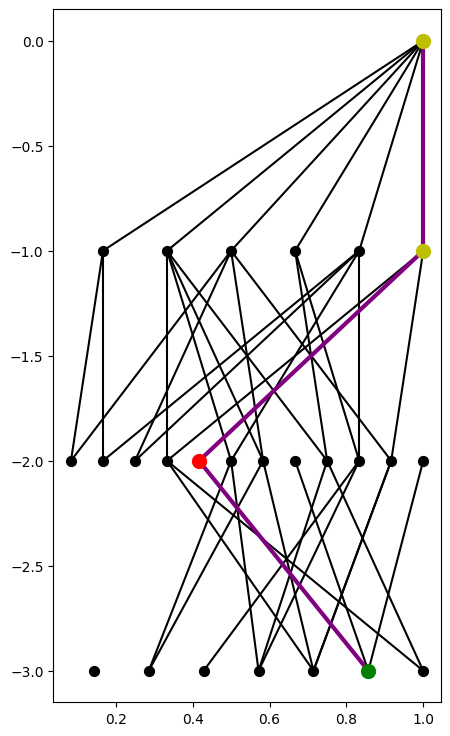

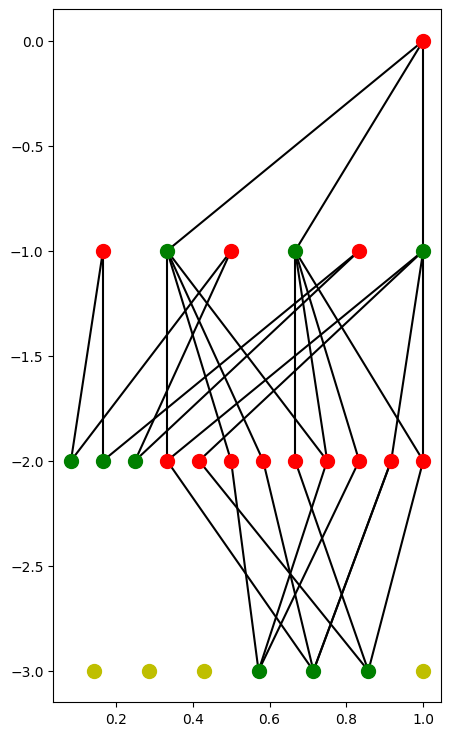

In [12]:
test_3tab = {'   ': [0,'1  &2  & 1 & 2 &  1&  2'],
             '1  ': [0,'12 &11 &1 1&1 2'],
             '2  ': [0,'22 &21 &2 1&2 2'],
             ' 1 ': [0,'11 &21 & 11& 12'],
             ' 2 ': [0,'12 &22 & 21& 22'],
             '  1': [0,'1 1&2 1& 11& 21'],
             '  2': [0,'1 2&2 2& 12& 22'],
             '11 ': [0,'111&112'],
             '12 ': [0,'121&121'],
             '21 ': [0,'211&212'],
             ' 11': [0,'111&211'],
             ' 12': [0,'112&212'],
             ' 21': [0,'121&221'],
             '2 1': [0,'211&221'],
             '1 2': [0,'112&122'],
             '1 1': [0,'111&121']}

U_test = Estimador(test_3tab,separador='&')
Partida_test = Partida(U_test.tablero('   '))
Partida_test.agregar_jugada(U_test.tablero('1  '))
Partida_test.agregar_jugada(U_test.tablero('1 2'))
Partida_test.agregar_jugada(U_test.tablero('112'))

U_test.tablero('112').cambiar_valor(1)
U_test.tablero('   ').visitado = True
U_test.tablero('1  ').visitado = True
U_test.tablero('1 2').visitado = True
U_test.tablero('112').visitado = True

fig1 = plt.figure(figsize=(5,9))
graficar_red(3,U_test,partida=Partida_test)
plt.show()

U_test.tablero('22 ').cambiar_valor(1)
U_test.tablero('2 2').cambiar_valor(1)
U_test.tablero(' 22').cambiar_valor(1)
U_test.tablero('112').cambiar_valor(1)
U_test.tablero('121').cambiar_valor(1)
U_test.tablero('211').cambiar_valor(1)

for llave in U_test.tableros:
  U_test.tablero(llave).visitado = True

fig2 = plt.figure(figsize=(5,9))
graficar_red(3,U_test)
plt.show()

del U_test
del test_3tab

### Graficar tablero (desuso)

#### Codigo

In [13]:
def llave_a_arreglo(n,m,llave):
  return [list(llave[i*m:(i+1)*m])  for i in range(n)]

def graficar_tablero(n,m,llave,scale=1,font=1,xscale=1,yscale=1):
  # tipear arreglo llave
  arreglo = llave_a_arreglo(n,m,llave)


  fig = plt.figure(figsize=(n,m))
  ejes = plt.gca()
  #_,ejes = plt.subplots() 
  #fig.patch.set_visible(False)
  ejes.axis('off')
  ejes.axis('tight')
  tablero = ejes.table(cellText=arreglo,
                       loc='center',
                       colWidths=[0.12]*m,
                       cellLoc = 'center')
  
  #fig.tight_layout()
  tablero.auto_set_font_size(False)
  tablero.set_fontsize(20*font*scale)
  tablero.scale(1*scale*xscale,2.5*scale*yscale)

# Bibliografia
#-sintaxis tabla: https://www.geeksforgeeks.org/how-to-create-a-table-with-matplotlib/
#-reajuste de escala tabla: https://stackoverflow.com/questions/15514005/how-to-change-the-tables-fontsize-with-matplotlib-pyplot
#-ajuste texto en celdas : https://stackoverflow.com/questions/25896964/centered-text-in-matplotlib-tables
#-documentacion: https://matplotlib.org/stable/api/table_api.html

#### Test

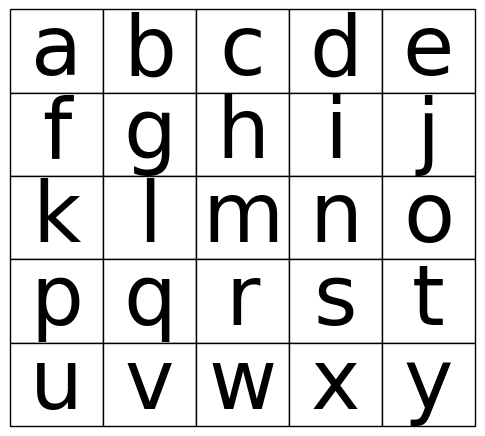

In [14]:
test_llave = 'abcdefghijklmnopqrstuvwxy'

graficar_tablero(5,5,test_llave,scale=2,font=1.5)

#test_fig.show() #no funciona, table plotea automaticamente

del test_llave
#del test_fig

['         ']
['x        ']
['x   o    ']
['xx  o    ']
['xxo o    ']
['xxo o x  ']
['xxooo x  ']
['xxoooxx  ']


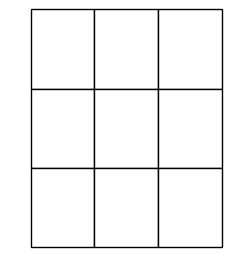

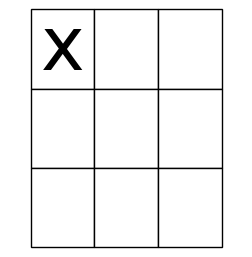

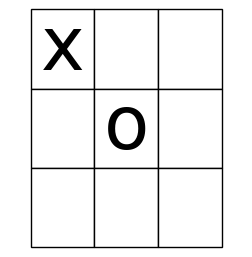

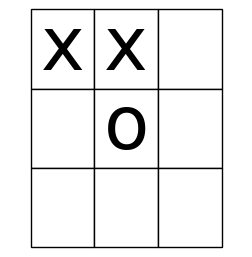

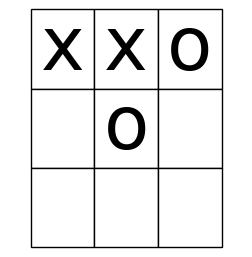

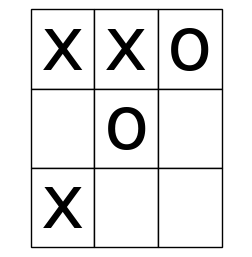

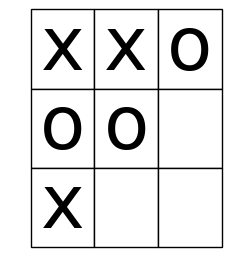

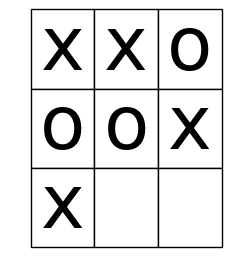

In [15]:
%matplotlib inline

test_gato = ['         ',
            'x        ',
            'x   o    ',
            'xx  o    ',
            'xxo o    ',
            'xxo o x  ',
            'xxooo x  ',
            'xxoooxx  ']

for tablero in test_gato:
  print([tablero])
  graficar_tablero(3,3,tablero,scale=1.9,xscale=1.2,font=1.4)

### Juego

#### Funcion de interfaz

In [16]:
### funcion de interfaz

def jugada_a_llave(columnas,filas,tablero,jugada):
  if len(tablero)!= filas*columnas:
    return ''
  try:  
    y = int(jugada[:jugada.find(',')])-1
  except:
    return ''
  if y < 0 or y >= filas:
    return ''
  try:
    x = int(jugada[jugada.find(',')+1:jugada.find(',',jugada.find(',')+1)])-1
  except:
    return ''
  if x < 0 or x >= columnas:
    return ''
  return tablero[:columnas*y+x]+jugada[-1]+tablero[columnas*y+x+1:]

In [17]:
### test llaves de jugadas

assert jugada_a_llave(3,1,'   ','1,1,1') == '1  '
assert jugada_a_llave(4,3,' '*12,'2,3,1') == '      1     '

#### Codigo

In [18]:
class Juego:
  def __init__(self,columnas=1,filas=1,llave_tablero_inicial=' '):
    self.palabra_segura = 'x' #desuso
    self.conocimiento = {} #desuso
    self.tablero_inicial = llave_tablero_inicial
    self.columnas = columnas
    self.filas = filas
    self.reglas = [lambda x: [],lambda x: []]
    self.victorias = [lambda x: True, lambda x: True]
    self.reiniciar()

  # reiniciar juego
  def reiniciar(self):
    self.jugador = 0 #desuso
    self.partida = [self.tablero_inicial] #desuso
    self.llaves_jugadas_posibles = self.reglas[0](self.tablero_inicial) #desuso

  # redefinir palabra segura (desuso)
  def cambiar_palabra_segura(self,palabra):
    self.palabra_segura = palabra

  # redefenir tamaño
  def cambiar_tablero(self,columnas,filas,llave_tablero_inicial):
    self.filas = filas
    self.columnas = columnas
    self.tablero_inicial = llave_tablero_inicial
    self.reiniciar()

  # redefinir reglas J1
  def cambiar_reglasJ1(self,regla):
    self.reglas = [regla]+self.reglas[1:]

  # redefinir reglas J2
  def cambiar_reglasJ2(self,regla):
    self.reglas = self.reglas[:1]+[regla]

  # redefinir condicion de victoria J1
  def cambiar_victoriaJ1(self,con_victoria):
    self.victorias = [con_victoria]+self.victorias[1:]

  # redefinir condicion de victoria J2
  def cambiar_victoriaJ2(self,con_victoria):
    self.victorias = self.victorias[:1]+[con_victoria]

  # saber si el juego acabo (desuso)
  def condicion_de_victoria(self):
    return self.victorias[1-self.jugador](self.llave_tablero_actual())

  # guardar "i.a." (desuso)
  def agregar_conocimiento(self,conocimiento):
    self.conocimiento.update(conocimiento)

  # probabilidad (desuso)
  def conocimiento_tablero(self,llave):
    if not llave in self.conocimiento:
      return 0.5
    return self.conocimiento[llave]

  # acceder a turno actual (desuso)
  def llave_tablero_actual(self):
    return self.partida[-1]

  # redefinir turno (desuso)
  def retroceder_antes_del_turno(self,n):
    self.partida = self.partida[:n]
    self.jugador = n%2-1
    self.llaves_jugadas_posibles = self.reglas[self.jugador](self.llave_tablero_actual()) 

  # agregar jugada (desuso)
  def agregar_jugada_manual(self,tablero_siguiente,llaves_tableros_siguientes):
    self.partida = self.partida+[tablero_siguiente]
    self.llaves_jugadas_posibles = llaves_tableros_siguientes
    self.jugador = 1 - self.jugador 

  # avanzar en juego (desuso)
  def agregar_jugada_jugador(self,jugada):
    llave = jugada_a_llave(self.columnas,self.filas,self.llave_tablero_actual(),jugada)
    #print('jugada:',[llave])

    if llave in self.llaves_jugadas_posibles: # checkear si es una jugada permitida
      self.partida = self.partida+[llave] # agregar jugada a la partida
      self.jugador = 1 - self.jugador #actualizar turno
      self.llaves_jugadas_posibles = self.reglas[self.jugador](llave) #actualizar jugadas siguientes
  
  # juega "i.a." (desuso)
  def agregar_jugada_modelo(self,determinista=False):
    if len(self.llaves_jugadas_posibles) == 0:
      return
    jugada_siguiente = self.llaves_jugadas_posibles[0] #iniciarlizado

    if determinista: # juega la mejor jugada posible
      valor_aux = 0
      for llave in self.llaves_jugadas_posibles:
        valor_actual_aux = self.conocimiento_tablero(llave)
        if valor_actual_aux > valor_aux: #checkear si es mejor de lo que ya tiene
          valor_aux = valor_actual_aux
          jugada_siguiente = llave      
    else: # elegir al azar
      u = np.random.random_sample() #jugada
      u = u*sum([self.conocimiento_tablero(llave) for llave in self.llaves_jugadas_posibles])
      valor_aux = 0
      for llave in self.llaves_jugadas_posibles: # invariante de entrada al loop: ninguna llave previa es la jugada seleccionada
        valor_aux+= self.conocimiento_tablero(llave)
        if valor_aux > u: # checkear si esta es la que salio sorteada
          jugada_siguiente = llave
          break

    self.partida = self.partida+[jugada_siguiente]
    self.jugador = 1 - self.jugador
    self.llaves_jugadas_posibles = self.reglas[self.jugador](jugada_siguiente)

  def jugar_turno(self,determinista=True):
    if self.condicion_de_victoria():
      print('partida finalizada')
      return
    jugador_aux = self.jugador
    while jugador_aux == self.jugador:
      jugada = input('jugada: ')
      if jugada == '':
        self.agregar_jugada_modelo(determinista)
        return
      if jugada == self.palabra_segura:
        print('partida suspendida')
        return
      self.agregar_jugada_jugador(jugada)

  def tablero_actual(self):
    #tablero = np.ndarray(shape=(self.filas,self.columnas),dtype=str)
    #for x in range(self.columnas):
    #  for y in range(self.filas):
    #    tablero[y,x] = self.llave_tablero_actual()[y*self.columnas + x]
    tablero = np.array(list(self.llave_tablero_actual())).reshape(self.filas,self.columnas)
    return tablero

#### Test


In [19]:
test_3tab = {'   ': [0,'1  &2  & 1 & 2 &  1&  2'],
             '1  ': [0,'12 &11 &1 1&1 2'],
             '2  ': [0,'22 &21 &2 1&2 2'],
             ' 1 ': [0,'11 &21 & 11& 12'],
             ' 2 ': [0,'12 &22 & 21& 22'],
             '  1': [0,'1 1&2 1& 11& 21'],
             '  2': [0,'1 2&2 2& 12& 22'],
             '11 ': [0,'111&112'],
             '12 ': [0,'121&121'],
             '21 ': [0,'211&212'],
             ' 11': [0,'111&211'],
             ' 12': [0,'112&212'],
             ' 21': [0,'121&221'],
             '2 1': [0,'211&221'],
             '1 2': [0,'112&122'],
             '1 1': [0,'111&121']}

U_test = Estimador(test_3tab,separador='&')

U_test.tablero('22 ').cambiar_valor(1)
U_test.tablero('2 2').cambiar_valor(1)
U_test.tablero(' 22').cambiar_valor(1)
U_test.tablero('112').cambiar_valor(1)
U_test.tablero('121').cambiar_valor(1)
U_test.tablero('211').cambiar_valor(1)

U_test.actualizar_tableros_viables('222',True)
U_test.actualizar_tableros_viables('221',True)
U_test.actualizar_tableros_viables('212',True)
U_test.actualizar_tableros_viables('122',True)
U_test.actualizar_tableros_viables('211',True)
U_test.actualizar_tableros_viables('121',True)
U_test.actualizar_tableros_viables('112',True)
U_test.actualizar_tableros_viables('22 ',True)
U_test.actualizar_tableros_viables('21 ',True)
U_test.actualizar_tableros_viables('2 2',True)
U_test.actualizar_tableros_viables('2 1',True)
U_test.actualizar_tableros_viables('12 ',True)
U_test.actualizar_tableros_viables('11 ',True)
U_test.actualizar_tableros_viables('1 2',True)
U_test.actualizar_tableros_viables('1 1',True)
U_test.actualizar_tableros_viables(' 22',True)
U_test.actualizar_tableros_viables(' 21',True)
U_test.actualizar_tableros_viables(' 12',True)
U_test.actualizar_tableros_viables(' 11',True)
U_test.actualizar_tableros_viables('2  ',True)
U_test.actualizar_tableros_viables('1  ',True)
U_test.actualizar_tableros_viables(' 2 ',True)
U_test.actualizar_tableros_viables(' 1 ',True)
U_test.actualizar_tableros_viables('  2',True)
U_test.actualizar_tableros_viables('  1',True)
U_test.actualizar_tableros_viables('   ',True)

conocimiento_test = {}

for llave in U_test.tableros:
  conocimiento_test[llave] = U_test.valor(llave)

def regla_test(llave):
  jugadas_posibles = []
  for indice in range(len(llave)):
    if llave[indice] == ' ':
      jugadas_posibles.append(llave[:indice]+'1'+llave[indice+1:])
      jugadas_posibles.append(llave[:indice]+'2'+llave[indice+1:])
  return jugadas_posibles

assert regla_test('   ') == ['1  ','2  ',' 1 ',' 2 ','  1','  2']

def con_vic_test(llave):
  valor = 0
  for casilla in llave:
    if casilla != ' ':
      valor+= int(casilla)
  return valor == 4

assert not con_vic_test('   ')
assert con_vic_test(' 13')

In [20]:
juego_test = Juego(3,1,'   ')
juego_test.cambiar_reglasJ1(regla_test)
juego_test.cambiar_reglasJ2(regla_test)
juego_test.cambiar_victoriaJ1(con_vic_test)
juego_test.cambiar_victoriaJ2(con_vic_test)
juego_test.agregar_conocimiento(conocimiento_test)

In [21]:
#juego_test.reiniciar()
#for turnos in range(3):
#  print([juego_test.tablero_actual()])
#  juego_test.jugar_turno(False)

#print([juego_test.tablero_actual()])


In [22]:
del juego_test
del U_test
del conocimiento_test
del regla_test

## Parte 1.3: Modelo

### GPI

#### Codigo

In [23]:
def MonteCarlo(u,distribucion):
  acumulado_aux = 0

  # invariante de entrada al loop: u no ha caido en ningun indice previo
  for indice in range(len(distribucion)): 
    acumulado_aux+= distribucion[indice]
    if acumulado_aux >= u: # checkear si esta es la que salio sorteada
      return indice
  
  # boton de panico (?)
  return -1

In [24]:
# modelo
class GPI:
  def __init__(self,juego,separador='&'):
    self.jugador = 0
    self.juego = juego
    self.estimador = Estimador(separador=separador)
    self.partida = Partida(self.estimador.tablero(self.juego.tablero_inicial))
  
  # simular un turno
  def jugar_turno(self,u,llave_tablero):
    # greedy: se sabe que todas las jugadas viables tienen la misma utilidad
    distribucion = np.array([1]*len(self.estimador.jugadas_viables(llave_tablero)))
    distribucion = distribucion/sum(distribucion) # estandarizar
    eleccion = MonteCarlo(u,distribucion)

    jugada = self.estimador.jugadas_viables(llave_tablero)[eleccion]

    self.partida.agregar_jugada(self.estimador.tablero(jugada))
    self.jugador = 1-self.jugador

  # simular resto de una partida
  def simular_partida(self,U,actualizar=False):
    estado_actual = self.partida.tablero_actual().llave
    turno = self.partida.turno_actual()

    # verificar si se puede jugar
    #if len(self.estimador.jugadas_viables(estado_actual)) == 0:
    if not self.estimador.tablero(estado_actual).visitado:

      # guardar que se revisó
      self.estimador.tablero(estado_actual).visitado = True

      # verificar si es porque el jugador anterior ganó  
      if self.juego.victorias[1-self.jugador](estado_actual):
        if actualizar:
          self.estimador.tablero(estado_actual).cambiar_valor(1)
        return
      
      # intentar actualizar
      jugadas_siguientes = self.juego.reglas[self.jugador](estado_actual)
      self.estimador.agregar_tablero(estado_actual,jugadas_siguientes)

    # si sigue vacio: no se puede seguir jugando
    if len(self.estimador.jugadas_viables(estado_actual)) == 0:
      return

    self.jugar_turno(U[turno],estado_actual)
    self.simular_partida(U,True) # continuar jugando

  def Iteracion(self,u,U):
    largo_de_la_partida = self.partida.turno_actual()
    perdedor = self.jugador
    if self.partida.tablero_actual().valor < 1:
      #greedy: darle la oportunidad a quien no gana
      perdedor = 1-perdedor
    lista_jugadas_posibles = []
    
    # greedy: elegir solo jugadas del perdedor para asegurar que termine en otra partida
    for turno in range(perdedor,largo_de_la_partida+1,2):
      llave_tablero_en_turno = self.partida.tablero_en_turno(turno).llave
      lista_jugadas_posibles.append(self.estimador.jugadas_viables(llave_tablero_en_turno))

    # greedy: últimos turnos son más probables
    beta = 1
    distribucion_turno = 1-np.exp(-beta*(np.array([(turno+1)*len(lista_jugadas_posibles[turno]) for turno in range(len(lista_jugadas_posibles))])))
    # este jugador tiene mejores jugadas
    if sum(distribucion_turno) > 0:
      distribucion_turno = distribucion_turno/sum(distribucion_turno) #estandarizar
      turno_elegido = perdedor + 2*MonteCarlo(u,distribucion_turno)
      self.partida.retroceder_antes_del_turno(turno_elegido+1)
      self.jugador = perdedor
      #print('cambiar:',turno_elegido,'para que juege ',self.jugador)
    
    #for tablero in self.partida.tableros:
    #  print([tablero.llave],':',tablero.llaves_jugadas_posibles_viables())

    self.simular_partida(U,actualizar=True)

    estado = self.partida.tablero_actual().llave
    #jugador = self.partida.turno_actual()%2

    #if self.juego.victorias[1-jugador]:
    #self.partida.tablero_actual().cambiar_valor(1)
    self.actualizar(estado)      

  def actualizar(self,llave):
    lista_por_actualizar = set(self.estimador.tablero(llave).tableros_de_origen)
    while len(lista_por_actualizar) > 0:
      lista_aux = []
      for tablero in lista_por_actualizar:
        #print(tablero.llave,'actualizado')
        tablero.actualizar_tableros_viables()
        lista_aux+= tablero.tableros_de_origen
      lista_por_actualizar=set(lista_aux)
  

#### Test

## Parte 1.4: Demo

### Demo 1: 3-tab-(4,[2])

* Se juega sobre un tablero de 1x3
* Cada jugador puede poner número 1 ó 2 en una casilla vacía
* Gana quien primero haga que la suma de los valor en el tablero sea 4. 

#### Definiciones

In [25]:
# oraculo de reglas
def ReglasTab42(llave):
  jugadas_posibles = []
  for indice in range(len(llave)):
    if llave[indice] != ' ':
      continue
    jugadas_posibles.append(llave[:indice]+'1'+llave[indice+1:])
    jugadas_posibles.append(llave[:indice]+'2'+llave[indice+1:])
  return jugadas_posibles

# oraculo de condicion de victoria
def CondicionVictoriaTab42(llave):
  total = sum([int(i) for i in llave if i != ' '])
  return total == 4

Entrenamiento

In [26]:
Tab42 = Juego(3,1,' '*3)
Tab42.cambiar_reglasJ1(ReglasTab42)
Tab42.cambiar_reglasJ2(ReglasTab42)
Tab42.cambiar_victoriaJ1(CondicionVictoriaTab42)
Tab42.cambiar_victoriaJ2(CondicionVictoriaTab42)

Demo1 = GPI(Tab42)

In [27]:
def AnimacionRed(frame):
  graficar_red(Demo1.estimador,Demo1.partida)
  Demo1.Iteracion(u[frame],U[frame])

In [28]:
n = 10
np.random.seed(42)
U = np.random.rand(n,3)
u = np.random.rand(n)

FigTab42 = plt.Figure()
animacionTab42 = FuncAnimation(FigTab42, AnimacionRed, frames=n, interval=100)

#video = animacionTab42.to_html5_video()
#html = display.HTML(video)
#display.display(html)
#plt.show() 
# good practice to close the plt object.
#plt.close()
plt.show()

### Demo 2: Gato



*   Se juega sobre un tablero de 3x3.
*   Jugador 1 rellena casillas con una 'x';
*   Jugador 2 rellena casillas con una 'o'.
*   Gana quien primero forme una linea recta con 3 simbolos iguales.



#### definiciones

https://www.geeksforgeeks.org/create-an-animated-gif-using-python-matplotlib/

In [29]:
# oraculo de reglas
def ReglasGato(llave,ficha):
  jugadas_posibles = []
  # regla: pone una "ficha" en cualquier casilla vacia
  for indice in range(len(llave)):
    if llave[indice] != ' ':
      continue
    jugadas_posibles.append(llave[:indice]+ficha+llave[indice+1:])
  return jugadas_posibles  

# reglas jugador 1
def ReglasGatoJugador1(llave):
  return ReglasGato(llave,'x')

# reglas jugador 2
def ReglasGatoJugador2(llave):
  return ReglasGato(llave,'o')


# oraculo condicion de victoria
def CondicionVictoriaGato(llave,palabra):
  # gana cuando: forma una palabra en una de las siguientes lineas

  # lineas horizontales
  for fila in range(3):
    if llave[fila*3:(fila+1)*3] == palabra:
      return True

  # lineas verticales
  for columna in range(3):
    if llave[columna]+llave[columna+3]+llave[columna+6] == palabra:
      return True

  # lineas diagonales
  if llave[0]+llave[4]+llave[8] == palabra:
    return True

  if llave[2]+llave[4]+llave[6] == palabra:
    return True

  # no hay condicion de victoria
  return False

# condicion de victoria jugador 1
def CondicionVictoriaGatoJ1(llave):
    return CondicionVictoriaGato(llave,'xxx')

# condicion de victoria jugador 2
def CondicionVictoriaGatoJ2(llave):
    return CondicionVictoriaGato(llave,'ooo')

#### Entrenamiento

In [30]:
Gato = Juego(3,3,' '*9)
Gato.cambiar_reglasJ1(ReglasGatoJugador1)
Gato.cambiar_reglasJ2(ReglasGatoJugador2)
Gato.cambiar_victoriaJ1(CondicionVictoriaGatoJ1)
Gato.cambiar_victoriaJ2(CondicionVictoriaGatoJ2)

figGato = {}

Demo2 = GPI(Gato)

In [31]:
n = 1
np.random.seed(1)
U = np.random.rand(n,10)
u = np.random.rand(n)

for i in range(n):
  Demo2.Iteracion(u[i],U[i])

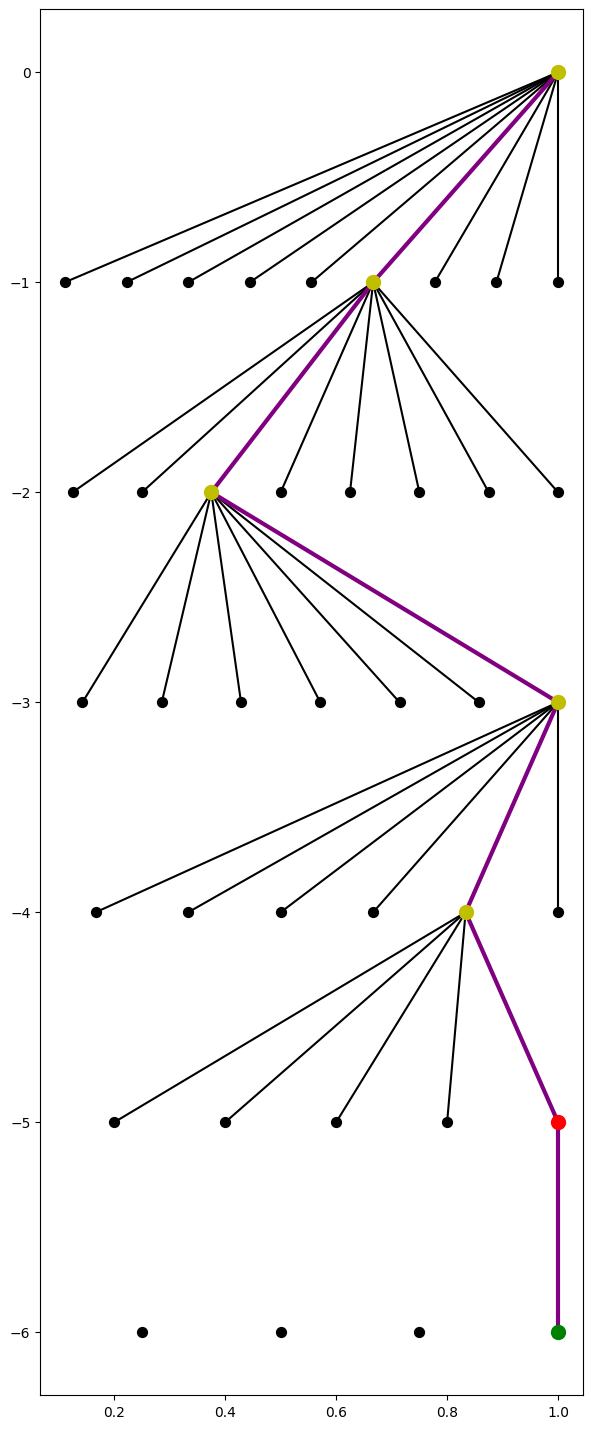

In [32]:
figGato[1] = plt.figure(figsize=(7,18))
graficar_red(9,Demo2.estimador,Demo2.partida)
plt.show()

In [33]:
n = 9
np.random.seed(12)
U = np.random.rand(n,9)
u = np.random.rand(n)

for i in range(n):
  Demo2.Iteracion(u[i],U[i])

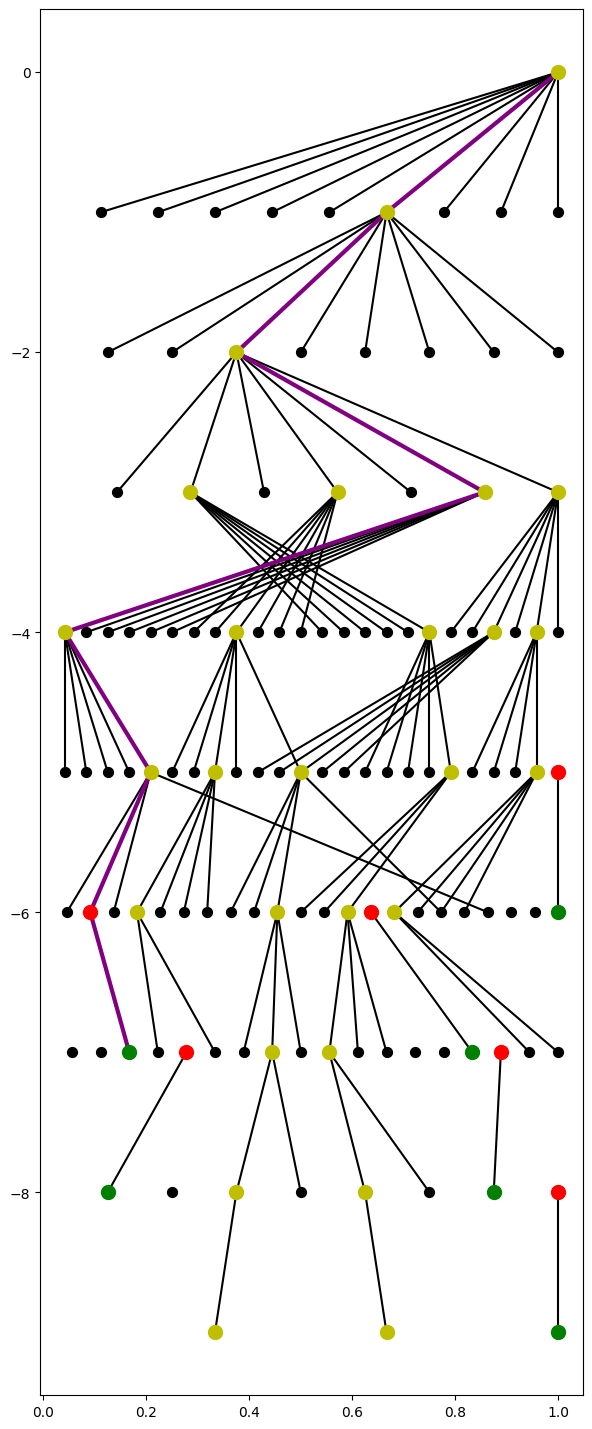

In [34]:
figGato[2] = plt.figure(figsize=(7,18))
graficar_red(9,Demo2.estimador,Demo2.partida)
plt.show()

In [35]:
n = 90
np.random.seed(123)
U = np.random.rand(n,9)
u = np.random.rand(n)

for i in range(n):
  Demo2.Iteracion(u[i],U[i])

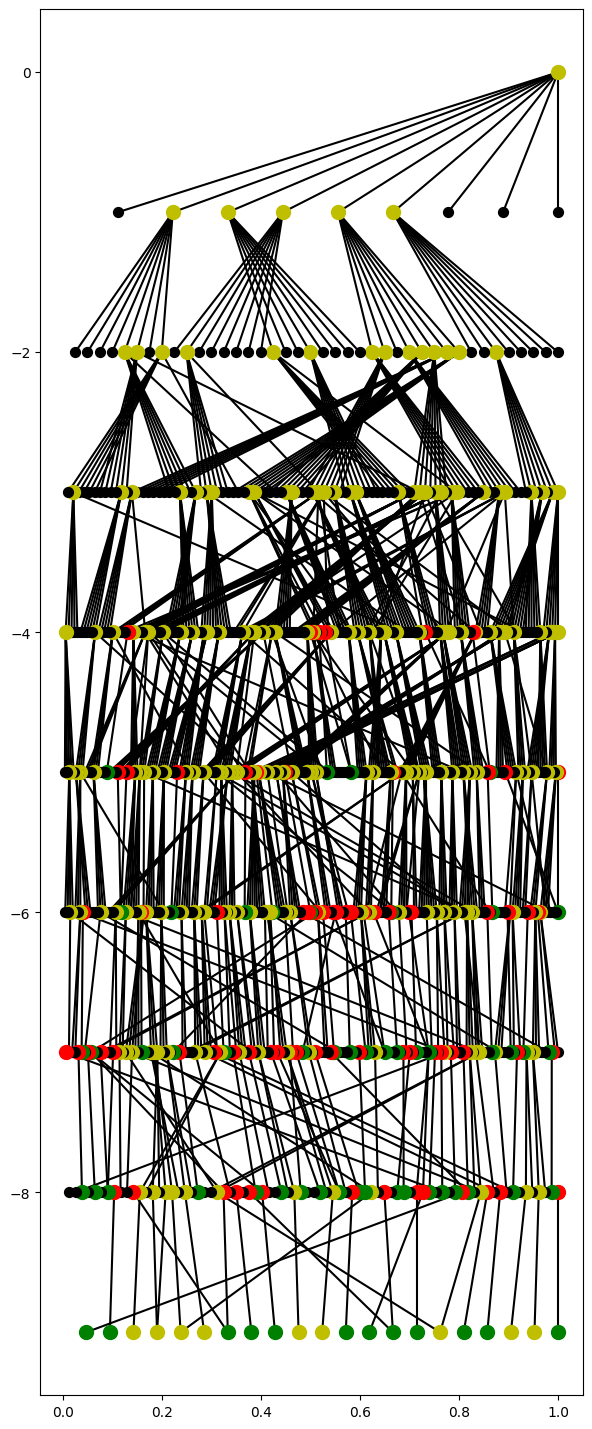

In [36]:
figGato[3] = plt.figure(figsize=(7,18))
graficar_red(9,Demo2.estimador)
plt.show()

In [37]:
n = 900
np.random.seed(1234)
U = np.random.rand(n,9)
u = np.random.rand(n)

for i in range(n):
  Demo2.Iteracion(u[i],U[i])

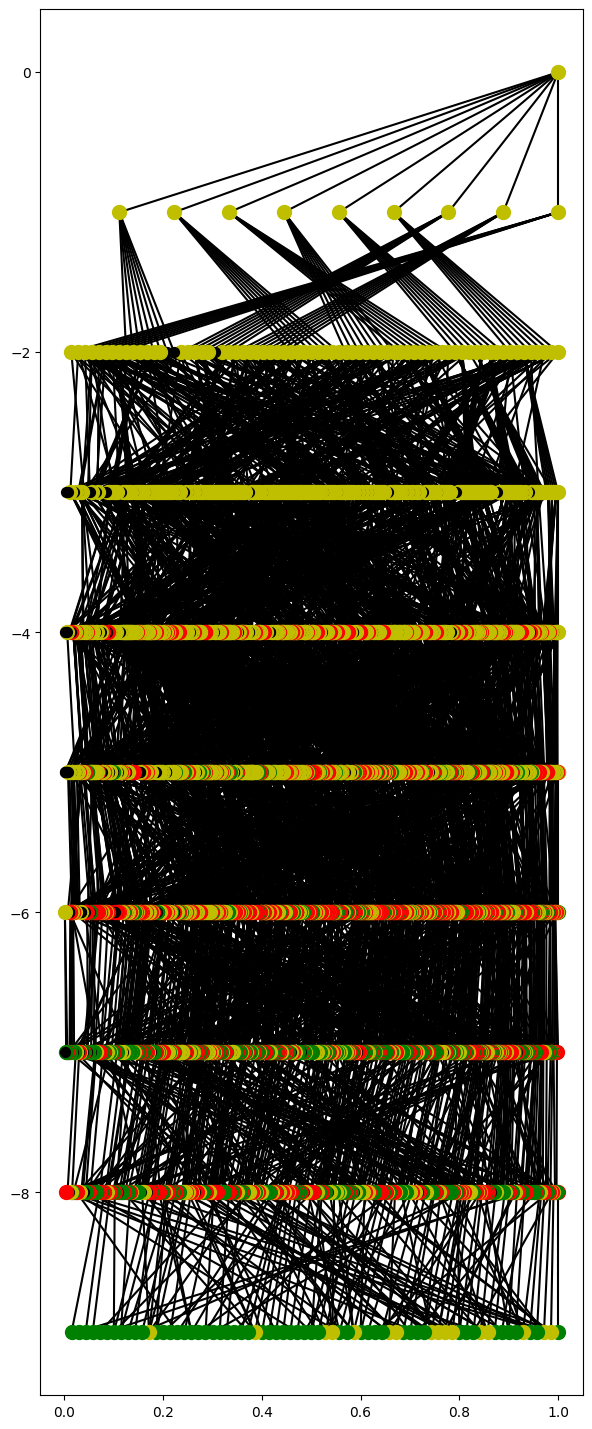

In [38]:
figGato[4] = plt.figure(figsize=(7,18))
graficar_red(9,Demo2.estimador)

#### Comparacion

In [39]:
estimador_gato_backtracking = {}
estimador_gato_backtracking[' '*9] = [0, False, Gato.reglas[0](' '*9)]

def BackTracking(juego,estimador,llave,jugador):
  if ' ' not in llave:
    if estimador[llave][1]:
      estimador[llave] = [1]+estimador[llave][1:]
      return
    estimador[llave] = [0,True,[]]
    return

  if estimador[llave][1]:
    estimador[llave] = [1]+estimador[llave][1:]
    return

  for siguiente in estimador[llave][2]:
    aux = -1
    if siguiente not in estimador:
      estimador[siguiente] = [0,juego.victorias[jugador](siguiente),juego.reglas[1-jugador](siguiente)]
      BackTracking(juego,estimador,siguiente,1-jugador)
    aux = max(aux,estimador[siguiente][0])
  estimador[llave] = [-aux]+estimador[llave][1:]


BackTracking(Gato,estimador_gato_backtracking,' '*9,0)


In [40]:
total_tableros_gato = len(estimador_gato_backtracking)
total_tableros_hoja_gato = len([llave for llave in estimador_gato_backtracking if estimador_gato_backtracking[llave][1]==True])
tableros_visitados_gato = [llave for llave in Demo2.estimador.tableros if Demo2.estimador.tablero(llave).visitado]
total_tableros_visitados_gato = len(tableros_visitados_gato)
lista_auxiliar = [llave for llave in tableros_visitados_gato if len(Demo2.estimador.jugadas_viables(llave))==0]
total_tableros_hoja_visitados_gato = len(lista_auxiliar)
#for llave in lista_auxiliar:
#  if ' ' not in llave:
#    tableros_hoja_visitados_gato+= 1
#    continue
#  jugador = len([i for i in llave if i==' '])%2
#  if Gato.victorias[jugador](llave):
#    tableros_hoja_visitados_gato+= 1

print('cantidad total de hojas:',total_tableros_hoja_gato)
print('cantidad de hojas visitadas:',total_tableros_hoja_visitados_gato)
print('proporcion:',total_tableros_hoja_visitados_gato/total_tableros_hoja_gato)
print('cantidad total de tableros:',total_tableros_gato)
print('cantidad de tableros visitados:',total_tableros_visitados_gato)
print('proporcion:',total_tableros_visitados_gato/total_tableros_gato)

cantidad total de hojas: 958
cantidad de hojas visitadas: 406
proporcion: 0.42379958246346555
cantidad total de tableros: 5478
cantidad de tableros visitados: 2459
proporcion: 0.4488864549105513


#### Juego

### Demo 3: abc

* Se juega en un tablero de 5x5
* Cada jugador puede rellenar una casilla con alguna de las letras 'a', 'b' o 'c'
* Gana quien primero forme una palabra con las 3 letras en alguna direccion ortogonal

#### Definiciones

In [41]:
# oraculo de reglas
def ReglasABC(llave):
  jugadas_posibles = []
  for indice in range(len(llave)):
    if llave[indice] != ' ':
      continue
    jugadas_posibles.append(llave[:indice]+'A'+llave[indice+1:])
    jugadas_posibles.append(llave[:indice]+'B'+llave[indice+1:])
    jugadas_posibles.append(llave[:indice]+'C'+llave[indice+1:])
  return jugadas_posibles

# oraculo de condicion de victoria
def CondicionVictoriaABC(llave):
  # horizontal
  for fila in range(5):
    for columna in range(3):
      palabra = llave[5*fila + columna:5*fila+columna+3]
      if 'A' in palabra:
        if 'B' in palabra:
          if 'C' in palabra:
            return True
  
  #vertical
  for columna in range(5):
    for fila in range(3):
      palabra = llave[5*fila + columna]+llave[5*(fila+1)+columna]+llave[5*(fila+2)+columna]
      if 'A' in palabra:
        if 'B' in palabra:
          if 'C' in palabra:
            return True

  return False

#### Entrenamiento

In [42]:
ABC = Juego(5,5,' '*25)
ABC.cambiar_reglasJ1(ReglasABC)
ABC.cambiar_reglasJ2(ReglasABC)
ABC.cambiar_victoriaJ1(CondicionVictoriaABC)
ABC.cambiar_victoriaJ2(CondicionVictoriaABC)

Demo3 = GPI(ABC)

In [43]:
n = 50000
np.random.seed(123456)
U = np.random.rand(n,25)
u = np.random.rand(n)

for i in range(n):
  Demo3.Iteracion(u[i],U[i])

In [44]:
print(len(Demo3.estimador.tableros))

14311195
14311195


## Borrador

In [ ]:

def Montecarlo_MC(U,lista_jugadas_posibles,puntajes_conocidos):
  
  lista_puntajes = []
  for llave in lista_jugadas_posibles:
    try:
      puntaje_llave = puntajes_conocidos[llave]
    except:
      puntaje_llave = 0

    lista_puntajes.append(puntaje_llave)

  lista_puntajes_auxiliar = []
  lista_jugadas_posibles_auxiliar = []
  for i in range(len(lista_jugadas_posibles)):
    if lista_puntajes < 0:
      lista_jugadas_posibles_auxiliar.append(lista_jugadas_posibles[i])
      lista_puntajes_auxiliar.append(lista_puntajes[i])
  if len(lista_puntajes_auxiliar) == 0:
    lista_jugadas_posibles_auxiliar.append(lista_jugadas_posibles[0])
    lista_puntajes_auxiliar.append(lista_puntajes[0])
    for i in range(1,len(lista_jugadas_posibles)):
      if lista_puntajes[i] == lista_puntajes[0]:
        lista_jugadas_posibles_auxiliar.append(lista_jugadas_posibles[i])
        lista_puntajes_auxiliar.append(lista_puntajes[i])
      if lista_puntajes[i] < lista_puntajes[0]:
        lista_jugadas_posibles_auxiliar = list([lista_jugadas_posibles[i]])
        lista_puntajes_auxiliar= list([lista_puntajes[i]])
  eleccion = infimo_indice(U,lista_puntajes_auxiliar)

  return lista_jugadas_posibles_auxiliar[eleccion]

def infimo_indice(U,simplex):
  pass
  

def simular_partida(partida,puntajes_conocidos,jugadas_permitidas_del):
  if len(partida.turno_pasado.jugadas_posibles) == 0:
    return partida

  tablero_siguiente = Montecarlo_MC(partida.ultimo_turno.jugadas_posibles,puntajes_conocidos)
  jugadas_siguientes = jugadas_permitidas_del(tablero_siguiente)
  partida.agregar_jugada(tablero(tablero_siguiente,jugadas_siguientes))

  return partida

def jugar(llave_tablero_inicial,puntaje_conocido,jugadas_permitidas_del):
    tablero_actual = llave_tablero_inicial
    while(True):
      # imprimir tablero
      print(dibujo(tablero_actual))
      
      llaves_jugadas_posibles = jugadas_permitidas_del(tablero_actual)
      
      # checkear si se puede jugar
      if len(llaves_jugadas_posibles) == 0:
        print('fin de la partida')
        break

      # preguntar jugador que quiere jugar
      for i in range(len(llaves_jugadas_posibles)):
        print(i,llaves_jugadas_posibles)
      eleccion = input('eleccion (0,'+str(len(llaves_jugadas_posibles)+1)+') : ')

      # tratar de jugar
      try:
        tablero_actual = llaves_jugadas_posibles[eleccion]
      except:
        print('fin de la partida')
        break
      
      # imprimir jugada
      print(dibujo(tablero_actual))
      
      llaves_jugadas_posibles = jugadas_permitidas_del(tablero_actual)

      # checkear si se puede jugar
      if len(llaves_jugadas_posibles) == 0:
        print('fin de la partida')
        break

      # juega pc
      llave_eleccion = llaves_jugadas_posibles[0]
      try:
        mejor_valor = puntaje_conocido[llave_eleccion]
      except:
        mejor_valor = 0

      # buscar mejor jugada
      for llave_jugada in llaves_jugadas_posibles:
        try:
          valor_nuevo = puntaje_conocido[llave_jugada]
        except:
          valor_nuevo = 0

        # si jugar aqui hace menos probable que mi oponente gane: lo elijo
        if mejor_valor > valor_nuevo:
          llave_eleccion = llave_jugada
          mejor_valor = valor_nuevo
        
      tablero_actual = llave_eleccion

def dibujo(llave_tablero):
  pass

def Jugar(estimador,n,m,llave_tablero_inicial,jugador,reglas,con_victoria):
  llave_tablero_actual = llave_tablero_inicial
  jugadas_posibles = reglas[jugador](llave_tablero_actual) 
  graficar_tablero(n,m,llave_tablero_actual)
  while True:
    print([llave_tablero_actual])
    if con_victoria[jugador](llave_tablero_actual):
      print('fin de la partida')
      return
    jugada = input()
    print('jugada recibida:',jugada)
    if jugada != '':

      # boton de panico
      if jugada == 'fin':
        print('fin de la partida')
        break

      llave_jugada = jugada_a_llave(n,m,llave_tablero_actual,jugada)
      print([llave_jugada])
      # jugada jugador
      if llave_jugada in jugadas_posibles:
        print('jugada legal')
        llave_tablero_actual = llave_jugada
        jugador = 1 - jugador # 0 <-> 1
        jugadas_posibles = reglas[jugador](llave_tablero_actual)
        graficar_tablero(n,m,llave_tablero_actual)

      continue

    print('juega pc')
    print(estimador.jugadas_posibles(llave_tablero_actual))
    # jugada computador  
    if len(estimador.jugadas_posibles(llave_tablero_actual)) == 0:
      print('fin de la partida')
      break
    llave_tablero_actual = estimador.jugadas_posibles(llave_tablero_actual)[0]
    jugador = 1 - jugador # 0 <-> 1
    jugadas_posibles = reglas[jugador](llave_tablero_actual)
    graficar_tablero(n,m,llave_tablero_actual)
  return Jugar(estimador,n,m,llave_tablero_inicial,jugador,reglas,con_victoria)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f3cc5a0-8b19-4348-b678-1a94b87dc694' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>